In [ ]:
pip install tensorflow-addons

In [1]:
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# 공통 모듈 임포트
import pandas as pd
import numpy as np
import os

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 적재

In [3]:
train_og = pd.read_csv("/content/drive/MyDrive/건설기계 오일 상태 분류 AI 경진대회/train.csv")
test = pd.read_csv("/content/drive/MyDrive/건설기계 오일 상태 분류 AI 경진대회/test.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/건설기계 오일 상태 분류 AI 경진대회/sample_submission.csv")

test = test.drop(["ID", "YEAR"], axis=1)
columns = test.columns 

train_og2 = pd.concat([train_og[columns], train_og["Y_LABEL"]], axis=1)
train_og

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.0,4.0,6.0,216.0,1454.0,0,NaN,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.0,3.0,39.0,11261.0,41081.0,0,NaN,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,TRAIN_14090,COMPONENT3,1616,2014,8,200,0,2,201,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,135.4,16,0
14091,TRAIN_14091,COMPONENT1,2784,2013,2,200,0,3,85,0,...,NaN,NaN,NaN,NaN,NaN,0,14.5,117.5,1408,0
14092,TRAIN_14092,COMPONENT3,1788,2008,9,550,0,6,0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,54.0,1301,0
14093,TRAIN_14093,COMPONENT2,2498,2009,19,550,0,2,4,0,...,7.0,8.0,100.0,1625.0,18890.0,0,NaN,44.3,652,0


# 데이터 정보, 시각화

In [4]:
train_og2.head(3)

,COMPONENT_ARBITRARY,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,Y_LABEL
0,COMPONENT3,1486,200,0,0,13,78,888,0.0,16,1,6,8504,5,0,154.0,75,0
1,COMPONENT2,1350,375,0,0,0,31,2,0.0,0,0,0,19,0,0,44.0,652,0
2,COMPONENT2,2415,200,0,0,1,2,4,0.0,0,0,0,17,0,0,72.6,412,1


## data describe

In [5]:
train_og2.describe(include="all")

,COMPONENT_ARBITRARY,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,Y_LABEL
count,14095,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000
unique,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,COMPONENT3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,7050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3146.082937,387.416885,0.025825,0.028166,3.299468,34.560624,178.169280,0.033650,2.787939,23.992409,0.730117,415.159631,0.707911,0.050656,109.355815,588.646825,0.085349
std,NaN,4216.089809,550.016073,0.171926,0.314249,28.595510,128.958953,533.208976,0.809162,11.131836,59.833922,3.806716,1528.191012,6.897579,0.475438,49.612379,531.743393,0.279411
min,NaN,1000.000000,200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.900000,0.000000,0.000000
25%,NaN,1655.000000,200.000000,0.000000,0.000000,0.000000,1.000000,14.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,71.800000,37.000000,0.000000
50%,NaN,2227.000000,200.000000,0.000000,0.000000,1.000000,4.000000,41.000000,0.000000,1.000000,1.000000,0.000000,29.000000,0.000000,0.000000,111.300000,520.000000,0.000000
75%,NaN,3797.000000,410.000000,0.000000,0.000000,3.000000,17.000000,139.000000,0.000000,2.000000,7.000000,0.000000,181.000000,0.000000,0.000000,137.200000,1119.000000,0.000000


In [6]:
train_og2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   COMPONENT_ARBITRARY  14095 non-null  object 
 1   ANONYMOUS_1          14095 non-null  int64  
 2   ANONYMOUS_2          14095 non-null  int64  
 3   AG                   14095 non-null  int64  
 4   CO                   14095 non-null  int64  
 5   CR                   14095 non-null  int64  
 6   CU                   14095 non-null  int64  
 7   FE                   14095 non-null  int64  
 8   H2O                  14095 non-null  float64
 9   MN                   14095 non-null  int64  
 10  MO                   14095 non-null  int64  
 11  NI                   14095 non-null  int64  
 12  PQINDEX              14095 non-null  int64  
 13  TI                   14095 non-null  int64  
 14  V                    14095 non-null  int64  
 15  V40                  14095 non-null 

In [7]:
# numerical_columns = train_og2.select_dtypes(exclude='object').columns.tolist()

# def show_plot(df, columns):
#     fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16,16))
#     for i, column in enumerate(columns[:-1]):
#         row = int(i/4)
#         col = i%4
    
#         sns.histplot(df[column], ax=axs[row][col])

# show_plot(train_og2, numerical_columns)

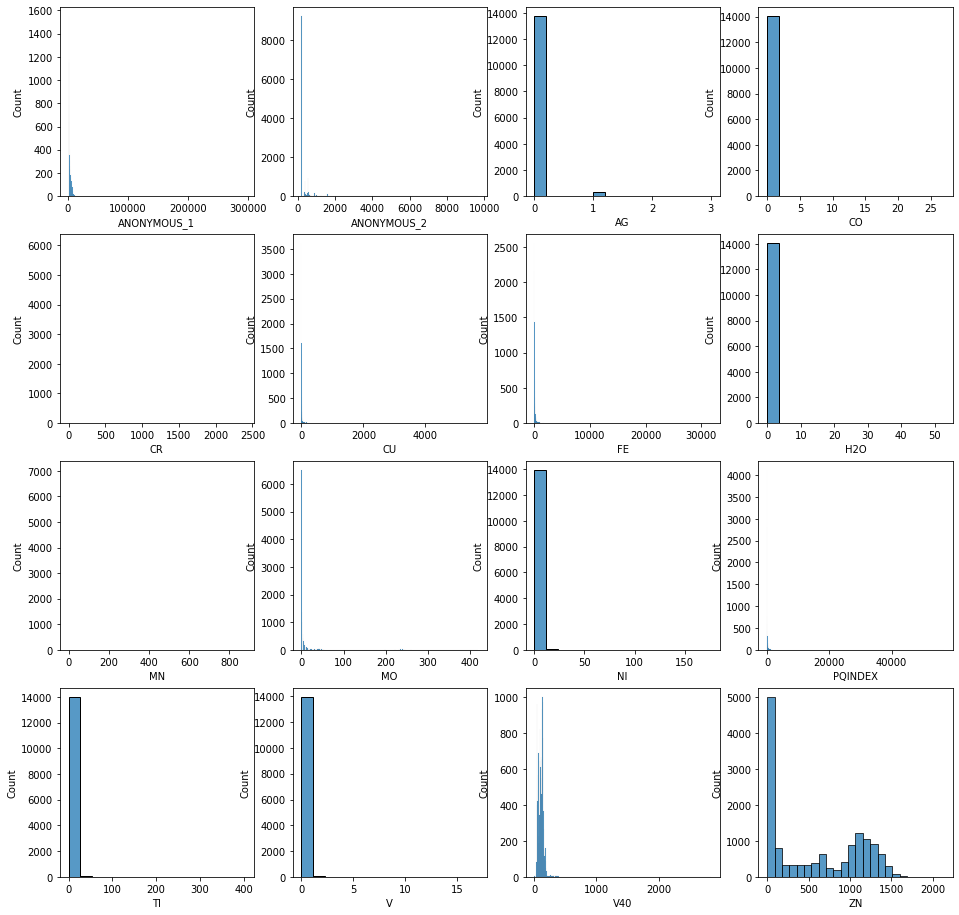

# 데이터 전처리

## one-hot encoding

In [8]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
train_component = ohe.fit_transform(train_og2[["COMPONENT_ARBITRARY"]])

train_component

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [9]:
train_og2 = train_og2.drop(["COMPONENT_ARBITRARY"], axis=1)
train_component = pd.DataFrame(data=train_component, columns=["component1","component2","component3","component4"])
train_og2 = pd.concat([train_og2, train_component], axis=1)
train_og2

,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,...,PQINDEX,TI,V,V40,ZN,Y_LABEL,component1,component2,component3,component4
0,1486,200,0,0,13,78,888,0.0,16,1,...,8504,5,0,154.0,75,0,0.0,0.0,1.0,0.0
1,1350,375,0,0,0,31,2,0.0,0,0,...,19,0,0,44.0,652,0,0.0,1.0,0.0,0.0
2,2415,200,0,0,1,2,4,0.0,0,0,...,17,0,0,72.6,412,1,0.0,1.0,0.0,0.0
3,7389,200,0,0,0,1,37,0.0,1,0,...,44,0,0,133.3,7,0,0.0,0.0,1.0,0.0
4,3954,200,0,0,0,0,71,0.0,0,0,...,217,0,0,133.1,128,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,1616,200,0,0,0,3,23,0.0,0,0,...,35,0,0,135.4,16,0,0.0,0.0,1.0,0.0
14091,2784,200,0,0,0,2,12,0.0,0,224,...,9,0,0,117.5,1408,0,1.0,0.0,0.0,0.0
14092,1788,550,0,0,4,7,415,0.0,7,10,...,645,0,0,54.0,1301,0,0.0,0.0,1.0,0.0
14093,2498,550,0,0,0,170,19,0.0,0,1,...,11,0,0,44.3,652,0,0.0,1.0,0.0,0.0


## 이상치 제거

In [10]:
# # 이상치 제거
# # 이상치 = Q3 + threshold * IQR 
# # 이상치가 너무 많음

# '''
# threshold를 기준으로 하니까 너무 데이터가 많이 삭제됨. 그래서 고정적으로 n개를 삭제하는 함수를 만들기로 결정함 
# '''

# def drop_outlier(df, threshold=1.5):
#     print(df.shape)
#     describe = df.describe()
#     for col in df.columns[:-5]:
#         IQR = describe.loc["75%",col] - describe.loc["25%", col]
#         outlier = describe.loc["75%",col] + IQR * threshold
#         outlier_data = df[df[col]>outlier].index
#         print("{}에서의 outlier 데이터 개수: {}".format(col, len(outlier_data)))
#         df = df.drop(df[df[col]>outlier].index, axis=0)
#     print(df.shape)
#     return outlier, df
# outlier, train = drop_outlier(train) 
# outlier

In [11]:
def drop_outlier(df, n=50):
    print("원래 데이터 크기: ",df.shape)
    outlier = pd.DataFrame()
    outlier_boundary = {}
    # 원핫 인코딩 된 컬럼은 이상치 제거 하지 않음.
    for i, col in enumerate(df.columns[:-5]):
        outlier_boundary[col] = df[col].sort_values(ascending=False).iloc[n]


    s = set()
    for col in outlier_boundary:
        outlier = pd.concat([outlier, df[df[col]>outlier_boundary[col]]], axis=0)
        s = s|set(outlier.index)

    df = df.drop(s)
    outlier = outlier.loc[~outlier.index.duplicated(keep='first')]
    print("이상치 제거 후 데이터 크기: ",df.shape)
    print("이상치 크기: ", outlier.shape)
    return  outlier, df, outlier_boundary
outlier, train, outlier_boundary= drop_outlier(train_og2) 

원래 데이터 크기:  (14095, 21)
이상치 제거 후 데이터 크기:  (13540, 21)
이상치 크기:  (555, 21)


In [12]:
outlier_boundary

{'ANONYMOUS_1': 15000,
 'ANONYMOUS_2': 5450,
 'AG': 1,
 'CO': 1,
 'CR': 74,
 'CU': 709,
 'FE': 3294,
 'H2O': 1.2,
 'MN': 65,
 'MO': 272,
 'NI': 24,
 'PQINDEX': 12688,
 'TI': 36,
 'V': 2,
 'V40': 323.3,
 'ZN': 1585}

In [13]:
train_X = train.drop(["Y_LABEL"], axis=1)
train_y = train.Y_LABEL

In [14]:
train_X

,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,component1,component2,component3,component4
0,1486,200,0,0,13,78,888,0.0,16,1,6,8504,5,0,154.0,75,0.0,0.0,1.0,0.0
1,1350,375,0,0,0,31,2,0.0,0,0,0,19,0,0,44.0,652,0.0,1.0,0.0,0.0
2,2415,200,0,0,1,2,4,0.0,0,0,0,17,0,0,72.6,412,0.0,1.0,0.0,0.0
3,7389,200,0,0,0,1,37,0.0,1,0,0,44,0,0,133.3,7,0.0,0.0,1.0,0.0
4,3954,200,0,0,0,0,71,0.0,0,0,0,217,0,0,133.1,128,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,1616,200,0,0,0,3,23,0.0,0,0,0,35,0,0,135.4,16,0.0,0.0,1.0,0.0
14091,2784,200,0,0,0,2,12,0.0,0,224,0,9,0,0,117.5,1408,1.0,0.0,0.0,0.0
14092,1788,550,0,0,4,7,415,0.0,7,10,1,645,0,0,54.0,1301,0.0,0.0,1.0,0.0
14093,2498,550,0,0,0,170,19,0.0,0,1,0,11,0,0,44.3,652,0.0,1.0,0.0,0.0


In [15]:
outlier_X = outlier.drop(["Y_LABEL"], axis=1)
outlier_y = outlier.Y_LABEL 

outlier_X

,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,component1,component2,component3,component4
75,21986,200,0,0,0,0,11,0.0,0,0,0,32,0,0,132.8,7,0.0,0.0,1.0,0.0
172,63454,900,0,0,0,10,24,0.0,8,7,0,10,0,0,64.7,1628,0.0,0.0,0.0,1.0
212,78418,200,0,0,0,1,17,0.0,0,0,0,16,0,0,134.0,35,0.0,0.0,1.0,0.0
589,39411,200,0,0,0,0,64,0.0,0,0,0,111,0,0,179.7,39,0.0,0.0,1.0,0.0
632,22327,200,0,0,0,0,38,0.0,0,0,0,368,0,0,130.8,6,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12432,2452,200,0,0,0,1,19,0.0,0,37,0,14,0,0,78.4,1601,0.0,0.0,0.0,1.0
13134,1774,200,1,0,9,7,110,0.0,2,89,2,126,0,0,135.0,2132,1.0,0.0,0.0,0.0
13220,1399,200,0,0,3,5,41,0.0,0,267,0,12,0,0,115.5,1664,1.0,0.0,0.0,0.0
13421,1231,200,0,0,2,9,67,0.0,1,50,1,47,1,0,122.3,1667,1.0,0.0,0.0,0.0


In [16]:
train_X.describe()

,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,component1,component2,component3,component4
count,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000
mean,2962.737740,365.198154,0.021492,0.015657,2.098375,28.918316,141.699852,0.005724,2.111817,23.042171,0.492393,318.734343,0.319645,0.024520,107.613812,588.922747,0.278951,0.169276,0.492171,0.059601
std,1959.400655,381.354828,0.145023,0.124150,4.135947,69.539256,296.487833,0.054291,4.988166,57.790573,1.623699,1023.551577,1.853138,0.174414,40.274936,527.459879,0.448500,0.375010,0.499957,0.236755
min,1000.000000,200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1651.000000,200.000000,0.000000,0.000000,0.000000,1.000000,14.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,71.200000,37.000000,0.000000,0.000000,0.000000,0.000000
50%,2210.000000,200.000000,0.000000,0.000000,1.000000,4.000000,40.000000,0.000000,0.000000,1.000000,0.000000,27.000000,0.000000,0.000000,110.350000,534.000000,0.000000,0.000000,0.000000,0.000000
75%,3767.000000,407.000000,0.000000,0.000000,2.000000,17.000000,130.000000,0.000000,2.000000,7.000000,0.000000,164.000000,0.000000,0.000000,136.700000,1117.000000,1.000000,0.000000,1.000000,0.000000
max,15000.000000,5450.000000,1.000000,1.000000,73.000000,695.000000,3294.000000,1.200000,65.000000,272.000000,24.000000,12688.000000,36.000000,2.000000,323.300000,1585.000000,1.000000,1.000000,1.000000,1.000000


## 정규화 하기

In [17]:
# 원핫인코딩된 컬럼을 제외하고 표준화 함(이상치 데이터는 정규화 하지 않는다).
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
standardized_train_X = pd.DataFrame(scaler.fit_transform(train_X.iloc[:, :-4]), columns = train_X.columns[:-4])


change_index = {}
for x, y in zip(standardized_train_X.index, train_X.index):
    change_index[x] = y

standardized_train_X = standardized_train_X.rename(change_index)
standardized_train_X = pd.concat([standardized_train_X, train_X.iloc[:, -4:]], axis=1)
standardized_train_X

,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,component1,component2,component3,component4
0,-0.753696,-0.433204,-0.148202,-0.12612,2.635920,0.705839,2.517229,-0.105432,2.784329,-0.381429,3.392137,7.997221,2.525730,-0.14059,1.151781,-0.974371,0.0,0.0,1.0,0.0
1,-0.823107,0.025704,-0.148202,-0.12612,-0.507369,0.029936,-0.471200,-0.105432,-0.423381,-0.398733,-0.303265,-0.292848,-0.172495,-0.14059,-1.579547,0.119591,0.0,1.0,0.0,0.0
2,-0.279554,-0.433204,-0.148202,-0.12612,-0.265578,-0.387110,-0.464454,-0.105432,-0.423381,-0.398733,-0.303265,-0.294802,-0.172495,-0.14059,-0.869402,-0.335436,0.0,1.0,0.0,0.0
3,2.259071,-0.433204,-0.148202,-0.12612,-0.507369,-0.401490,-0.353147,-0.105432,-0.222899,-0.398733,-0.303265,-0.268423,-0.172495,-0.14059,0.637795,-1.103296,0.0,0.0,1.0,0.0
4,0.505919,-0.433204,-0.148202,-0.12612,-0.507369,-0.415871,-0.238467,-0.105432,-0.423381,-0.398733,-0.303265,-0.099397,-0.172495,-0.14059,0.632829,-0.873886,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,-0.687347,-0.433204,-0.148202,-0.12612,-0.507369,-0.372729,-0.400368,-0.105432,-0.423381,-0.398733,-0.303265,-0.277216,-0.172495,-0.14059,0.689938,-1.086232,0.0,0.0,1.0,0.0
14091,-0.091224,-0.433204,-0.148202,-0.12612,-0.507369,-0.387110,-0.437470,-0.105432,-0.423381,3.477475,-0.303265,-0.302619,-0.172495,-0.14059,0.245477,1.552929,1.0,0.0,0.0,0.0
14092,-0.599561,0.484611,-0.148202,-0.12612,0.459797,-0.315205,0.921826,-0.105432,0.979992,-0.225688,0.312635,0.318770,-0.172495,-0.14059,-1.331245,1.350062,0.0,0.0,1.0,0.0
14093,-0.237192,0.484611,-0.148202,-0.12612,-0.507369,2.028881,-0.413860,-0.105432,-0.423381,-0.381429,-0.303265,-0.300665,-0.172495,-0.14059,-1.572098,0.119591,0.0,1.0,0.0,0.0


### 전처리 함수

In [18]:
def my_preprocessing(df, n=50):
    ohe = OneHotEncoder(sparse=False)
    df_component = ohe.fit_transform(df[["COMPONENT_ARBITRARY"]])
    df = df.drop(["COMPONENT_ARBITRARY"], axis=1)
    df_component = pd.DataFrame(data=df_component, columns=["component1","component2","component3","component4"])
    df = pd.concat([df, df_component], axis=1)


    outlier, train_X, outlier_boundary=drop_outlier(df, n)

    train = train_X.drop(["Y_LABEL"], axis=1)
    target = train_X.Y_LABEL

    outlier_X = outlier.drop(["Y_LABEL"], axis=1)
    outlier_y = outlier.Y_LABEL 


    return train, target, outlier_X, outlier_y

# 데이터셋 분류하기

In [19]:
# train_X, standardized_train_X, train_y, outlier_X, outlier_y
print("train_X shape: ", train_X.shape)
print("standardized_train_X shape: ", standardized_train_X.shape)
print("train_y shape: ", train_y.shape)
print("outlier_X shape: ", outlier_X.shape)
print("outlier_y shape: ", outlier_y.shape)

train_X shape:  (13540, 20)
standardized_train_X shape:  (13540, 20)
train_y shape:  (13540,)
outlier_X shape:  (555, 20)
outlier_y shape:  (555,)


## 검증셋 나누기

In [20]:
train_X, valid_X = train_X.iloc[2000:, :], train_X.iloc[:2000, :]
standardized_train_X , standardized_valid_X = standardized_train_X.iloc[2000:, :], standardized_train_X.iloc[:2000, :]
train_y, valid_y = train_y.iloc[2000:], train_y.iloc[:2000]
outlier_train_X, outlier_valid_X = outlier_X.iloc[150:, :], outlier_X.iloc[:150, :]
outlier_train_y, outlier_valid_y = outlier_y.iloc[150:], outlier_y.iloc[:150]

print("train_X shape: ", train_X.shape)
print("valid_X shape: ", valid_X.shape)
print("standardized_train_X shape: ", standardized_train_X.shape)
print("standardized_valid_X shape: ", standardized_valid_X.shape)
print("train_y shape: ", train_y.shape)
print("valid_y shape: ", valid_y.shape)
print("outlier_train_X shape: ", outlier_train_X.shape)
print("outlier_valid_X shape: ", outlier_valid_X.shape)
print("outlier_train_y shape: ", outlier_train_y.shape)
print("outlier_valid_y shape: ", outlier_valid_y.shape)

train_X shape:  (11540, 20)
valid_X shape:  (2000, 20)
standardized_train_X shape:  (11540, 20)
standardized_valid_X shape:  (2000, 20)
train_y shape:  (11540,)
valid_y shape:  (2000,)
outlier_train_X shape:  (405, 20)
outlier_valid_X shape:  (150, 20)
outlier_train_y shape:  (405,)
outlier_valid_y shape:  (150,)


# test 데이터 전처리

In [21]:
test_outlier = pd.DataFrame()
test_component = ohe.transform(test[["COMPONENT_ARBITRARY"]])
test_edit = test.drop(["COMPONENT_ARBITRARY"], axis=1)
test_component = pd.DataFrame(data=test_component, columns=["component1","component2","component3","component4"])
test_edit = pd.concat([test_edit, test_component], axis=1)

In [22]:
test_edit

,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,component1,component2,component3,component4
0,2192,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091,1.0,0.0,0.0,0.0
1,2794,200,0,0,2,1,278,0.0,3,0,0,2732,1,0,126.9,12,0.0,0.0,1.0,0.0
2,1982,200,0,0,0,16,5,0.0,0,0,0,11,0,0,44.3,714,0.0,1.0,0.0,0.0
3,1404,200,0,0,3,4,163,0.0,4,3,0,8007,0,0,142.8,94,0.0,0.0,1.0,0.0
4,8225,200,0,0,0,6,13,0.0,0,0,0,16,0,0,63.4,469,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,1714,200,0,0,3,130,1047,0.0,65,5,2,1999,0,0,71.2,1163,0.0,0.0,1.0,0.0
6037,4131,200,0,0,5,2,736,0.0,5,0,0,693,0,0,137.8,13,0.0,0.0,1.0,0.0
6038,4325,200,0,0,0,0,53,0.0,0,0,0,69,0,0,302.2,13,0.0,0.0,1.0,0.0
6039,1364,200,0,0,0,62,2,0.0,0,0,0,5,0,0,51.1,478,0.0,1.0,0.0,0.0


# 모델

## lgbm 모델
https://dacon.io/competitions/official/236013/talkboard/407263?page=1&dtype=recent 

위 링크에서 공유해주신 전략으로 한번 코드를 짜서 해보겠다.

## T 모델

----------------

### LGBM 모델을 위한 데이터 전처리

In [27]:
train_og3 = train_og.drop(["ID", "YEAR"], axis=1)

train_X2, train_y2, outlier_X2, outlier_y2 = my_preprocessing(train_og3)



train_X2 = train_X2.fillna(train_X2.mean())



scaler = preprocessing.StandardScaler()
standardized_train_X2 = pd.DataFrame(scaler.fit_transform(train_X2.iloc[:, :-4]), columns = train_X2.columns[:-4])


change_index = {}
for x, y in zip(standardized_train_X2.index, train_X2.index):
    change_index[x] = y


standardized_train_X2 = standardized_train_X2.rename(change_index)


standardized_train_X2 = pd.concat([standardized_train_X2, train_X2.iloc[:, -4:]], axis=1)

train_X2, valid_X2 = train_X2.iloc[2000:, :], train_X2.iloc[:2000, :]
standardized_train_X2 , standardized_valid_X2 = standardized_train_X2.iloc[2000:, :], standardized_train_X2.iloc[:2000, :]
train_y2, valid_y2 = train_y2.iloc[2000:], train_y2.iloc[:2000]


print("\ntrain_X2 shape: ", train_X2.shape)
print("valid_X2 shape: ", valid_X2.shape)
print("standardized_train_X2 shape: ", standardized_train_X2.shape)
print("standardized_valid_X2 shape: ", standardized_valid_X2.shape)
print("train_y2 shape: ", train_y2.shape)
print("valid_y2 shape: ", valid_y2.shape)

원래 데이터 크기:  (14095, 55)
이상치 제거 후 데이터 크기:  (12598, 55)
이상치 크기:  (1497, 55)

train_X2 shape:  (10598, 54)
valid_X2 shape:  (2000, 54)
standardized_train_X2 shape:  (10598, 54)
standardized_valid_X2 shape:  (2000, 54)
train_y2 shape:  (10598,)
valid_y2 shape:  (2000,)


### class weight를 적용한 LGBM 모델 학습 (lgbm_clf3)

In [28]:
evals = [(train_X2, train_y2), (valid_X2, valid_y2)]

lgbm_clf3 = LGBMClassifier(n_estimators=2000, learning_rate=0.05, num_leaves=64, class_weight='balanced')
lgbm_clf3.fit(train_X2, train_y2, early_stopping_rounds=50, eval_metric="binary_logloss"
                ,eval_set=evals, verbose=False)

pred3 = lgbm_clf3.predict(train_X2)
pred_proba3 = lgbm_clf3.predict_proba(train_X2)

target_proba3=[]

for elem in pred_proba3: 
    target_proba3.append(round(elem[0],2))
target_proba3 = np.array(target_proba3)


valid_pred3 = lgbm_clf3.predict(valid_X2)
valid_pred_proba3 = lgbm_clf3.predict_proba(valid_X2)

valid_target_proba3 = []
for elem in valid_pred_proba3: 
    valid_target_proba3.append(round(elem[0],2))

valid_target_proba3 = np.array(valid_target_proba3)

In [29]:
sklearn.metrics.accuracy_score(train_y2, pred3)

0.9985846386110587

## S 모델

### 적은 컬럼으로 LGBM 모델의 예측 라벨을 예측하는 분류 모델 (label_clf)

In [30]:
tf.random.set_seed(42)
np.random.seed(42)

# 모델 훈련
label_clf = keras.models.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation="sigmoid")
])

In [31]:
train_X.columns

Index(['ANONYMOUS_1', 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN',
       'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN', 'component1',
       'component2', 'component3', 'component4'],
      dtype='object')

In [65]:
# 조기종료를 수행하게 해주는 콜백
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
callbacks = [early_stopping_cb]

label_clf.compile(loss = tf.keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                    metrics = [tfa.metrics.F1Score(num_classes=1, average='macro')])

# 라벨별 가중치를 부여해서 더 정확하게 예측하는 데이터를 학습시킴.

label_clf.fit(train_X2[train_X.columns], pred3, epochs=40, 
              validation_data=(valid_X2[train_X.columns], valid_pred3), callbacks = callbacks)

Epoch 1/40
332/332 [==============================] - 4s 4ms/step - loss: 0.3026 - f1_score: 0.1520 - val_loss: 0.2459 - val_f1_score: 0.1016
Epoch 2/40
332/332 [==============================] - 1s 3ms/step - loss: 0.2974 - f1_score: 0.1520 - val_loss: 0.2409 - val_f1_score: 0.1016
Epoch 3/40
332/332 [==============================] - 1s 3ms/step - loss: 0.2954 - f1_score: 0.1520 - val_loss: 0.2387 - val_f1_score: 0.1016
Epoch 4/40
332/332 [==============================] - 1s 3ms/step - loss: 0.2954 - f1_score: 0.1520 - val_loss: 0.2379 - val_f1_score: 0.1016
Epoch 5/40
332/332 [==============================] - 1s 3ms/step - loss: 0.2930 - f1_score: 0.1520 - val_loss: 0.2353 - val_f1_score: 0.1016
Epoch 6/40
332/332 [==============================] - 1s 3ms/step - loss: 0.2918 - f1_score: 0.1520 - val_loss: 0.2330 - val_f1_score: 0.1016
Epoch 7/40
332/332 [==============================] - 1s 3ms/step - loss: 0.2917 - f1_score: 0.1520 - val_loss: 0.2316 - val_f1_score: 0.1016
Epoch 

In [66]:
p1 = label_clf.predict(train_X2[train_X.columns])
len(p1[p1>0.5])

332/332 [==============================] - 1s 2ms/step


48

In [67]:
for i, elem in enumerate(p1):
    if p1[i]>=0.5:
        p1[i]=1
    else:
        p1[i]=0

macro_f1 = f1_score(p1, train_y2, average="macro")
macro_f1

0.4903962810717323

### ~~적은 컬럼으로 LGM 모델의 proba를 예측하는 회귀 모델~~(폐기)

https://baeseongsu.github.io/posts/knowledge-distillation/

위 링크에 나온 모델을 구현해보자! 

1. 데이터의 가중치를 두어서 학습한다.
2. 데이터를 추가적으로 생성하서 학습한다.
3. 손실함수를 계산할 때 라벨도 계산하도록 손실함수를 만들어본다.

#### sample weight 구하기

In [35]:
from sklearn.utils.class_weight import compute_class_weight

compute_class_weight(class_weight = "balanced" , 
                     classes=np.unique(pred3), 
                     y = pred3)

array([0.5448283 , 6.07683486])

In [36]:
sample_weight = []
one_index = []
for i, elem in enumerate(pred3):
    if elem == 0:
        sample_weight.append(0.5448283)
    else:
        sample_weight.append(6.07683486)
        one_index.append(i)

sample_weight = np.array(sample_weight)

In [37]:
tf.random.set_seed(42)
np.random.seed(42)

# 모델 훈련
proba_reg = keras.models.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation="sigmoid")
])

In [59]:
# 조기종료를 수행하게 해주는 콜백
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
callbacks = [early_stopping_cb]

proba_reg.compile(loss = "mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

proba_reg.fit(train_X2[train_X.columns], target_proba3, epochs=30, 
              validation_data=(valid_X2[train_X.columns], valid_target_proba3), sample_weight = sample_weight, callbacks = callbacks)

Epoch 1/30
332/332 [==============================] - 2s 4ms/step - loss: 0.2102 - f1_score: 0.9398 - val_loss: 0.1992 - val_f1_score: 0.9492
Epoch 2/30
332/332 [==============================] - 1s 3ms/step - loss: 0.2103 - f1_score: 0.9398 - val_loss: 0.1959 - val_f1_score: 0.9492
Epoch 3/30
332/332 [==============================] - 1s 3ms/step - loss: 0.2119 - f1_score: 0.9398 - val_loss: 0.1985 - val_f1_score: 0.9492
Epoch 4/30
332/332 [==============================] - 1s 3ms/step - loss: 0.2097 - f1_score: 0.9398 - val_loss: 0.1966 - val_f1_score: 0.9492
Epoch 5/30
332/332 [==============================] - 1s 3ms/step - loss: 0.2096 - f1_score: 0.9398 - val_loss: 0.1976 - val_f1_score: 0.9492
Epoch 6/30
332/332 [==============================] - 1s 3ms/step - loss: 0.2083 - f1_score: 0.9398 - val_loss: 0.1976 - val_f1_score: 0.9492
Epoch 7/30
332/332 [==============================] - 1s 3ms/step - loss: 0.2088 - f1_score: 0.9398 - val_loss: 0.1977 - val_f1_score: 0.9492
Epoch 

In [40]:
wqer = proba_reg.predict(train_X2[train_X.columns])[one_index]

332/332 [==============================] - 1s 2ms/step


In [41]:
np.mean(wqer)

0.46623084

In [42]:
len(wqer)

872

In [43]:
p3 = proba_reg.predict(train_X2[train_X.columns])

332/332 [==============================] - 1s 2ms/step


In [45]:
len(wqer)

872

In [50]:
len(p3[p3>0.7])

871

In [ ]:
for i, elem in enumerate(p3):
    if p3[i]>=0.5:
        p3[i]=1
    else:
        p3[i]=0

macro_f1 = f1_score(p3, train_y2, average="macro")
macro_f1

### 사용자 지정 모델

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        
        ## Teature 모델이 sklearn LGBM 모델이여서 tensorflow 모델과 다름.
        ## 그래서 predict_proba 메서드를 사용함. 

        teacher_predictions = tf.convert_to_tensor(lgbm_clf3.predict_proba(train_X2), dtype=tf.float32)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
student = keras.models.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
distiller = Distiller(student=student, teacher=lgbm_clf3)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(train_X2[train_X.columns], target_proba, epochs=3)

# Evaluate student on test dataset


In [ ]:
teacher_predictions = tf.convert_to_tensor(lgbm_clf3.predict_proba(train_X2), dtype=tf.float32)

In [ ]:
teacher_predictions

# 모델 예측 / csv파일 저장

In [ ]:
def make_submission(model, test=test_edit, sample_submission=sample_submission):
    new_index = [x for x in range(1, 6042)]
    
    p = model.predict(test)
    for i, elem in enumerate(p):
        if p[i]>=0.5:
            p[i]=int(1)
        else:
            p[i]=int(0)
    sample_submission.Y_LABEL = np.int32(p)

    sample_submission=sample_submission.set_index("ID")
    return sample_submission

In [ ]:
lgbm_pred2 = make_submission(label_reg)

In [ ]:
lgbm_pred2.to_csv("/content/drive/MyDrive/건설기계 오일 상태 분류 AI 경진대회/predict/lgbm_pred2.csv")